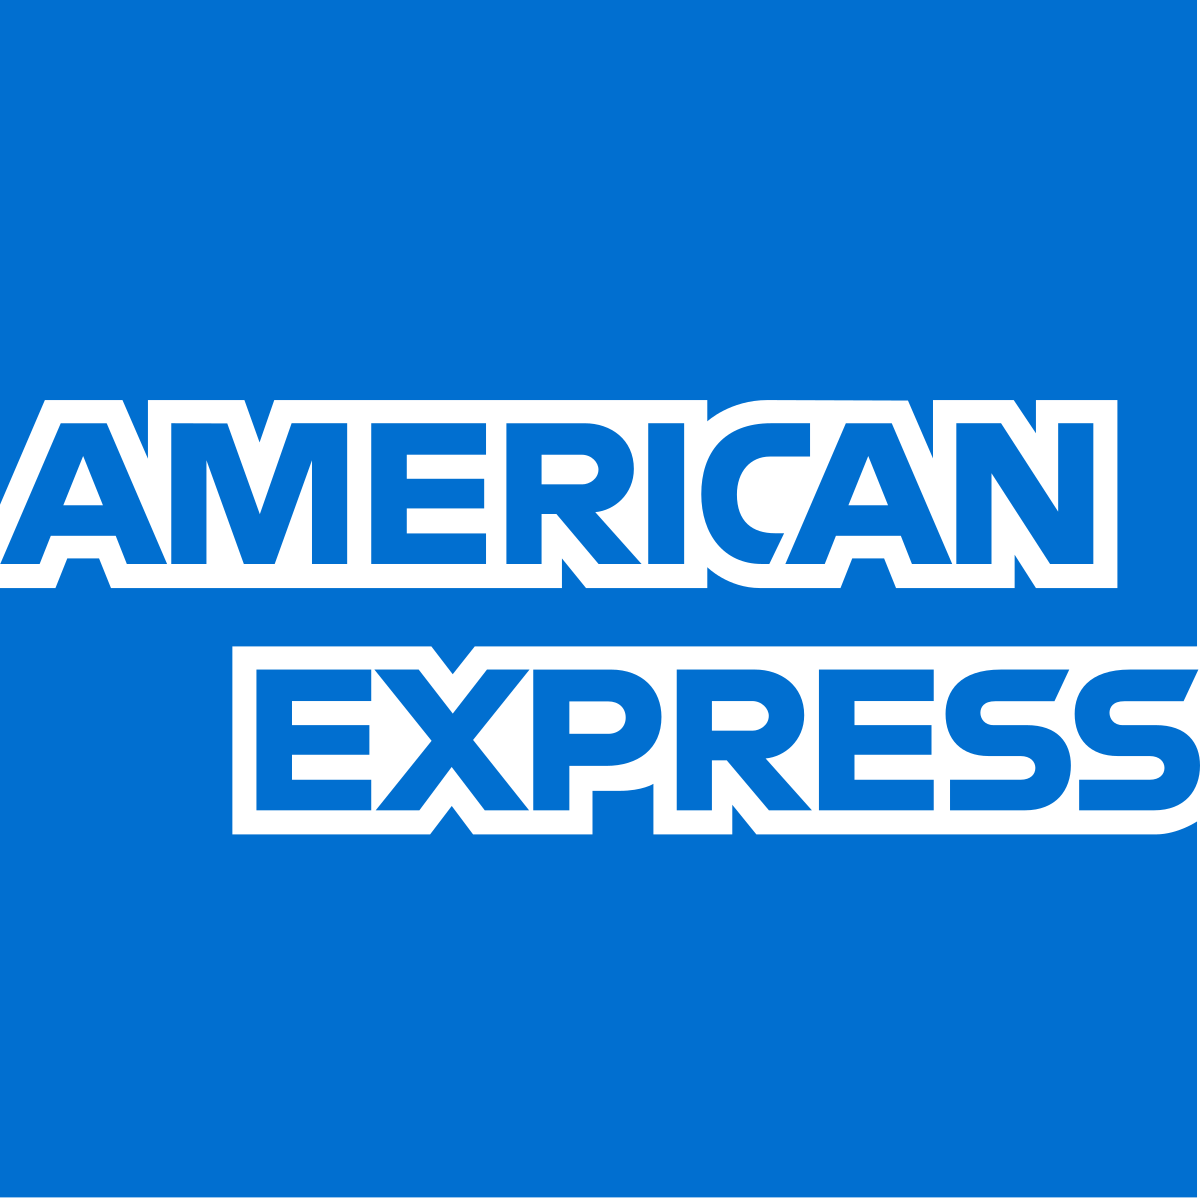

# Competition
---

・[American Express - Default Prediction](https://www.kaggle.com/competitions/amex-default-prediction)

# Description
---

レストランでの食事やコンサートのチケット購入など、現代の生活では日々の買い物にクレジットカードの利便性が欠かせません。<br>
クレジットカードがあれば、多額の現金を持ち歩く必要がなく、また、買い物の全額を前払いして、長期にわたって支払うことができます。<br>
しかし、カード発行会社は、私たちが請求した金額をきちんと返済してくれることをどうやって確認するのでしょうか？<br>
この問題は複雑で、多くの解決策がありますが、このコンペティションでは、さらに多くの改善策が検討されています。

貸し倒れ予測は、消費者金融ビジネスのリスク管理の中心的存在です。<br>
貸し倒れを予測することで、貸し出しの決定を最適化し、より良い顧客体験と健全なビジネス経済を実現することができます。<br>
現在のモデルは、リスク管理を支援するために存在しています。<br>
しかし、現在使用されているモデルを凌駕する、より優れたモデルを作成することは可能です。

アメリカン・エキスプレスは、世界的に統合された決済企業です。<br>
世界最大の決済カード発行会社である同社は、生活を豊かにし、ビジネスの成功をもたらす商品、洞察、体験へのアクセスを顧客に提供しています。

このコンペティションでは、機械学習のスキルを応用して、クレジット・デフォルトを予測します。<br>
具体的には、産業界規模のデータセットを活用し、現在の生産モデルに挑戦する機械学習モデルを構築していただきます。<br>
トレーニング、検証、テストの各データセットには、時系列行動データおよび匿名化された顧客プロファイル情報が含まれます。<br>
特徴量の作成から、モデル内でのデータの有機的な利用まで、最も強力なモデルを作るためのあらゆる手法を自由に探求することができます。

成功すれば、クレジットカードの審査が通りやすくなり、カード会員にとってより良い顧客体験の創造に貢献できます。<br>
優れたソリューションは、世界最大のクレジットカード発行会社が使用しているクレジットデフォルト予測モデルに挑戦し、<br>
賞金やアメリカン・エキスプレスとの面接の機会、そしてやりがいのある新しいキャリアを獲得する可能性があります。

# Evaluation
___

### Submission File
テスト集合の各 customer_ID に対して、ターゲット変数の確率を予測する必要があります。<br>
ファイルはヘッダを含み、以下のフォーマットである必要があります。

# Timeline
---

2022年5月25日 - 開始日。<br>
2022年8月17日 - エントリー締切日。出場するには、この日までに競技規則に同意する必要があります。<br>
2022年8月17日 - チーム合併の締切日。この日が、参加者がチームに参加したり合併したりできる最後の日です。<br>
2022年8月24日 - 最終提出締切日。<br>

すべての締め切りは、特に断りのない限り、該当する日の午後11時59分（UTC）です。<br>
日本時間では、2022年8月25日 午前8時59分（JTC）となります。<br>
大会主催者は、必要と判断した場合、コンテストのスケジュールを更新する権利を有します。

# Data
---

このコンペティションの目的は、毎月の顧客プロファイルに基づいて、ある顧客が将来クレジットカードの残高額を返済しない確率を予測することです。<br>
ターゲットのバイナリ変数は、最新のクレジットカード明細書の後、18ヶ月のパフォーマンスウィンドウを観察することによって計算され、<br>
もし顧客が最新の明細書の日付から120日以内に返済額を支払わない場合は、デフォルトイベントとみなされます。

データセットには、各顧客の各明細書日付における集約されたプロファイル特徴が含まれています。<br>
特徴は匿名化、正規化されており、以下の一般的なカテゴリーに分類されます。

`D_*` = 延滞変数<br>
`S_*` = 支出変数<br>
`P_*` = 支払い変数<br>
`B_*` = 残高変数<br>
`R_*` = リスク変数<br>

であり、以下の特徴はカテゴリ的である。

[`B_30`, `B_38`, `d_114`, `d_116`, `d_117`, `d_120`, `d_126`, `d_63`, `d_64`, `d_66`, `d_68`]

あなたのタスクは、各 `customer_ID` について、将来の支払い不履行の確率を予測することです。（`target = 1`）<br>
このデータセットでは、ネガティブ・クラスは5%でサブサンプルされているので、スコアリング・メトリックでは20倍の重み付けを受けることに注意してください。

# Library
---

In [ ]:
import gc
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
sns.set()
pd.set_option('display.max_rows', 200)

# Dataset
---

In [ ]:
train = pd.read_pickle('../input/creating-smaller-train-test-data/amex_train_data.pkl')
print(train.shape)
train.head(10)

In [ ]:
labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv')
print(labels.shape)
labels.head(10)

In [ ]:
sample_submission = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
print(sample_submission.shape)
sample_submission.head(10)

# EDA
---

### Train

In [ ]:
print(train.shape)
train.head(10)

In [ ]:
data = pd.DataFrame(['D_*', 'S_*', 'P_*', 'B_*', 'R_*'], columns=['カラム'])
data['意味'] = ['延滞変数', '支出変数', '支払い変数', '残高変数', 'リスク変数']
data

In [ ]:
pd.DataFrame(train.isnull().sum(), columns=['isnull'])

In [ ]:
pd.DataFrame(train.nunique(), columns=['nunique'])

In [ ]:
figure ,ax = plt.subplots(1, 2, figsize=(12,5))

train['target'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('target')
ax[0].set_ylabel('')

sns.countplot(x='target', data=train, ax=ax[1])
ax[1].set_title('target')

plt.show()

# Preprocess
---

In [ ]:
train = train.groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index().drop(['S_2'], axis='columns')
print(train.shape)
train.head()

In [ ]:
X_train = train[[col for col in train.columns if col != 'target']]
y_train = pd.DataFrame(train['target'])

print(X_train.shape)
print(y_train.shape)

In [ ]:
cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']

In [ ]:
for col in cat_cols:
    X_train[col] = X_train[col].astype('category')

In [ ]:
del train
gc.collect()

# Metric
---

In [ ]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

# Model
---

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=22)

In [ ]:
y_val = pd.DataFrame(y_val)

In [ ]:
'''
def create_model(trial):
    num_leaves = trial.suggest_int('num_leaves', 2, 31)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)
    bagging_freq = trial.suggest_int('bagging_freq', 1, 7)
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    
    model = lgb.LGBMClassifier(
        num_leaves=num_leaves,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth, 
        min_child_samples=min_child_samples, 
        min_data_in_leaf=min_data_in_leaf,
        bagging_freq=bagging_freq,
        bagging_fraction=bagging_fraction,
        feature_fraction=feature_fraction,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=666)
        
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_tr, y_tr, categorical_feature = cat_cols)
    y_pred = y_val.copy(deep=True)
    y_pred = y_pred.rename(columns={'target':'prediction'})
    y_pred['prediction'] = model.predict_proba(X_val)[:,1]
    score = amex_metric(y_val, y_pred)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)
params = study.best_params

print(params)
'''

In [ ]:
params = {'num_leaves': 22,
          'n_estimators': 264,
          'learning_rate': 0.06612339248781801,
          'max_depth': 8,
          'min_child_samples': 548,
          'min_data_in_leaf': 27,
          'bagging_freq': 7,
          'bagging_fraction': 0.7938573920363178,
          'feature_fraction': 0.36695559140359413,
          'subsample': 0.8223893456213397,
          'colsample_bytree': 0.6109251160779336,
          'random_state': 22}

In [ ]:
cls = lgb.LGBMClassifier(**params)
cls.fit(X_train, y_train)

In [ ]:
fig,ax = plt.subplots(figsize=(30, 30))
lgb.plot_importance(cls, ax=ax,importance_type='gain',max_num_features=190)
plt.show()

In [ ]:
del X_train, y_train, X_tr, X_val, y_tr, y_val
gc.collect()

# Prediction
---

In [ ]:
test = pd.read_pickle('../input/creating-smaller-train-test-data/amex_test_data.pkl')
test = test.groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index().drop(['S_2'], axis='columns')

In [ ]:
X_test = test.copy()

In [ ]:
cat_cols = [col for col in X_test.columns if X_test[col].dtype == 'object']

In [ ]:
for col in cat_cols:
    X_test[col] = X_test[col].astype('category')

In [ ]:
y_pred = cls.predict_proba(X_test)[:, 1]

# Submit

In [ ]:
submission = sample_submission.copy()
submission['prediction'] = y_pred

In [ ]:
submission.to_csv('submission.csv', index=False)
pd.read_csv('submission.csv').head(10)